In [149]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import yfinance as yf

In [150]:
df = yf.download("AMZN", start="2016-10-01", end=dt.date.today(), auto_adjust=True)
df.columns = [i.lower() for i in df.columns]
print(df.head())
df.info()
df.describe()



[*********************100%%**********************]  1 of 1 completed

                 open       high        low      close    volume
Date                                                            
2016-10-03  41.799999  41.993000  41.562500  41.837002  55388000
2016-10-04  42.045502  42.118500  41.513000  41.701500  59006000
2016-10-05  41.900002  42.283501  41.806000  42.217999  69382000
2016-10-06  42.185001  42.360500  42.029999  42.083000  53680000
2016-10-07  42.289501  42.297501  41.872501  41.971500  48524000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1915 entries, 2016-10-03 to 2024-05-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1915 non-null   float64
 1   high    1915 non-null   float64
 2   low     1915 non-null   float64
 3   close   1915 non-null   float64
 4   volume  1915 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 89.8 KB


,open,high,low,close,volume
count,1915.000000,1915.000000,1915.000000,1915.000000,1.915000e+03
mean,110.559228,111.839264,109.163106,110.523933,7.861899e+07
std,42.677683,43.188903,42.130520,42.640432,3.901955e+07
min,36.500000,37.162998,35.505001,35.953499,1.762600e+07
25%,82.454750,83.613750,81.286751,82.140503,5.310300e+07
50%,100.750000,101.786003,99.494499,100.550003,6.723000e+07
75%,153.545746,155.109497,151.300499,153.395004,9.245200e+07
max,189.160004,191.699997,187.440002,189.500000,3.313000e+08


In [151]:
#fill in missing dates using linear interpolation
df = df.resample('D').interpolate()

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2780 entries, 2016-10-03 to 2024-05-13
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2780 non-null   float64
 1   high    2780 non-null   float64
 2   low     2780 non-null   float64
 3   close   2780 non-null   float64
 4   volume  2780 non-null   float64
dtypes: float64(5)
memory usage: 130.3 KB


,open,high,low,close,volume
count,2780.000000,2780.000000,2780.000000,2780.000000,2.780000e+03
mean,110.485192,111.764760,109.080196,110.452576,7.936013e+07
std,42.654569,43.164905,42.108935,42.623330,3.899660e+07
min,36.500000,37.162998,35.505001,35.953499,1.762600e+07
25%,82.324291,83.485628,81.095627,82.045624,5.342150e+07
50%,100.775002,101.806002,99.614501,100.595001,6.775730e+07
75%,153.559998,155.011253,151.187469,153.396126,9.335080e+07
max,189.160004,191.699997,187.440002,189.500000,3.313000e+08


In [152]:
df['daily_varitation'] = (df['high'] - df['low'])/df['open']
# df['timestamp'] = df.index.astype(np.int64) // 10**9
df['daily_return'] = df['close'].pct_change()
df['7day_sma'] = df['close'].rolling(window=7).mean()
df['7day_std'] = df['close'].rolling(window=7).std()
df['7day_sma+2std'] = df['7day_sma'] + 2*df['7day_std']
df['7day_sma-2std'] = df['7day_sma'] - 2*df['7day_std']
df['high_close_diff'] = df['high'] - df['close']
df['low_open_diff'] = df['low'] - df['open']
# df['cumulative_return'] = (1 + df['daily_return']).cumprod()
df['14day_ema'] = df['close'].ewm(span=14, adjust=False).mean()
# df['rsi'] = 100 - (100 / (1 + (df['close'].diff().fillna(0).rolling(window=14).apply(lambda x: x[x > 0].sum(), raw=True) / df['close'].diff().fillna(0).rolling(window=14).apply(lambda x: x[x < 0].sum(), raw=True))))
df['macd'] = df['close'].ewm(span=12, adjust=False).mean() - df['close'].ewm(span=26, adjust=False).mean()
df['stochastic_oscillator'] = (df['close'] - df['low'].rolling(window=14).min()) / (df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())
df['atr'] = df[['high', 'low', 'close']].apply(lambda x: max(x['high'] - x['low'], abs(x['high'] - np.roll(x['close'], 1)), abs(x['low'] - np.roll(x['close'], 1))), axis=1)

df.info()
print(df[df.isnull().any(axis=1)].index)

df = df[df.index >= '2016-10-16']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2780 entries, 2016-10-03 to 2024-05-13
Freq: D
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   open                   2780 non-null   float64
 1   high                   2780 non-null   float64
 2   low                    2780 non-null   float64
 3   close                  2780 non-null   float64
 4   volume                 2780 non-null   float64
 5   daily_varitation       2780 non-null   float64
 6   daily_return           2779 non-null   float64
 7   7day_sma               2774 non-null   float64
 8   7day_std               2774 non-null   float64
 9   7day_sma+2std          2774 non-null   float64
 10  7day_sma-2std          2774 non-null   float64
 11  high_close_diff        2780 non-null   float64
 12  low_open_diff          2780 non-null   float64
 13  14day_ema              2780 non-null   float64
 14  macd                   2780 no

In [153]:
#show which rows contain infinity or value too larger for float
df.describe()

,open,high,low,close,volume,daily_varitation,daily_return,7day_sma,7day_std,7day_sma+2std,7day_sma-2std,high_close_diff,low_open_diff,14day_ema,macd,stochastic_oscillator,atr
count,2767.000000,2767.000000,2767.000000,2767.000000,2.767000e+03,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000
mean,110.807198,112.092258,109.397243,110.775338,7.947595e+07,0.023682,0.000677,110.617139,1.739677,114.096493,107.137785,1.316920,-1.409956,110.436399,0.356438,0.567404,2.695015
std,42.494491,43.000247,41.952262,42.461756,3.904498e+07,0.013525,0.016086,42.397695,1.411009,43.774014,41.169069,1.384475,1.406331,42.281689,2.128043,0.302166,1.805640
min,36.500000,37.162998,35.505001,35.953499,1.762600e+07,0.003738,-0.140494,36.773357,0.029395,37.786465,34.757586,0.000000,-10.343491,37.668232,-11.233165,0.000000,0.159500
25%,82.800003,83.794250,81.498501,82.674165,5.346613e+07,0.014219,-0.005337,82.571786,0.697667,85.586348,80.019195,0.316588,-1.998501,82.475098,-0.686676,0.293506,1.209000
50%,100.855499,102.199997,99.800003,100.883001,6.786133e+07,0.020199,0.000780,100.336785,1.370766,104.475605,96.823654,0.849503,-0.948502,99.873968,0.485051,0.614513,2.450500
75%,153.655251,155.109497,151.447250,153.416250,9.360200e+07,0.029311,0.006159,153.419107,2.350819,158.050162,147.738999,1.865335,-0.395251,153.463565,1.565225,0.842523,3.691668
max,189.160004,191.699997,187.440002,189.500000,3.313000e+08,0.102855,0.135359,188.212379,9.849481,194.329603,186.586129,12.014496,0.000000,185.916132,7.260353,1.000000,13.794998


In [154]:
# you need to run this \/ (to be added to anaconda)
# pip install nltk 

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

articles = pd.read_csv('articles.csv')

articles_dict = {}
for index, row in articles.iterrows():
    date = row['date']
    if date in articles_dict:
        articles_dict[date].append(row['title'])
    else:
        articles_dict[date] = [row['title']]

print(articles_dict)
sentiments = []
for index, row in df.iterrows():    
    date = index.strftime('%Y-%m-%d')
    sentiment = 0
    count = 0
    if date in articles_dict:
        for article in articles_dict[date]:
            sentiment += analyzer.polarity_scores(article)['compound']
            count += 1
    if (count > 0):
        sentiment = sentiment / count
    sentiments.append(sentiment)



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\48503\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'2024-05-13': ['Super Micro Computer Stock Forecast: Can SMCI Hit $1,200 Again?'], '2024-05-12': ['Why Microsoft Stock Is the Pick of the Magnificent Seven Litter', 'Elon Musk’s Next Billion-Dollar Venture Is in Motion Right Now', 'The 3 Best Space Stocks to Buy in May 2024', '3 Game-Changing Stocks to Unlock Life-Changing Wealth', 'GOOG Stock Analysis: Unlocking the Future Potential of Alphabet in 2024'], '2024-05-11': ["AI Revolution 'On the Doorstep:' The 'Tidal Wave' Is Well Underway, Analyst Says", 'Why We’re Excited for the Next Wave of AI Growth', '3 Blue-Chip Tech Stocks Attracting Institutional Investor Attention', 'The 3 Best Mutual Funds to Buy in May 2024', 'AMD Stock Alert: Why You Should Sell Advanced Micro Devices Now', 'Cloud Computing Kings: 3 Stocks Ruling the Remote Work Era'], '2024-05-10': ["Funko's Q1 loss sliced 60%, names new CEO", 'Streaming Wars Winners: 3 Stocks Conquering the Content Game', 'Overlooked AI Gems: 3 Under-the-Radar Stocks With Massive Potentia

In [155]:
# print non zero sentiments
non_zero_sentiments = [sentiment for sentiment in sentiments if sentiment != 0]
print(non_zero_sentiments)
print(sentiments)
df['sentiment'] = sentiments

[-0.32985, 0.106975, 0.1779, -0.05103333333333334, -0.14940000000000003, -0.1531, 0.11269999999999998, 0.18286666666666665, 0.312875, 0.015128571428571427, 0.1574666666666667, 0.31245, 0.0772, 0.18200000000000002, 0.09353333333333334, 0.5994, 0.15595, -0.013066666666666671, -0.082725, 0.15337142857142858, -0.019033333333333347, -0.5574, 0.13073333333333334, 0.2066125, 0.38695, 0.4224, 0.16138, 0.09, 0.55115, 0.0431, 0.1645625, -0.050614285714285716, 0.0593, 0.2678, 0.20355714285714285, 0.17649999999999996, 0.15568888888888888, 0.1779, -0.3182, 0.18386666666666668, 0.12734, 0.23537999999999998, -0.11234999999999998, 0.4201, 0.06743333333333333, 0.1278, 0.1147083333333333, 0.06620000000000001, 0.08895, -0.32389999999999997, 0.10846, 0.4074, 0.09276666666666666, 0.264025, 0.3767, -0.14920000000000003, 0.43392499999999995, 0.044475, 0.5994, 0.1779, 0.14894285714285713, -0.26934, -0.05403333333333334, 0.08084, 0.28595, 0.093, 0.04845384615384617, -0.09090000000000001, -0.2023, 0.36605, 0.60

In [164]:
# evaluate the relevance of features based on mutual information and pvalues
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

def evaluate_mutual_information(X, y):
    mi = mutual_info_regression(X, y)
    f_test, p_values = f_regression(X, y)
    return mi, p_values

X = df.drop(columns=['close'])
y = df['close']

test = SelectKBest(score_func=f_regression, k='all')
fit = test.fit(X, y)

model = LogisticRegression()
rfe = RFE(model, n_features_to_select=1)

mi, p_values = evaluate_mutual_information(X, y)

rnd_clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X, y)

results = pd.DataFrame({'feature': X.columns.values, 'mi': mi, 'p_values': p_values, 'importance': rnd_clf.feature_importances_, 'kBest': fit.scores_})
print(results.sort_values(by='importance', ascending=False))
    

c:\programming\ml\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\programming\ml\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Num Features: 
 1
Selected Features: 
 [False False False False False False False False False False False False
 False False False  True False]
Feature Ranking: 
 [ 7  6 11 17 14 16  4 15 12 10 13  9  5  3  2  1  8]
                  feature        mi       p_values  importance         kBest
0                    open  3.125569   0.000000e+00    0.001902  1.506990e+06
1                    high  3.700132   0.000000e+00    0.477477  3.101274e+06
2                     low  3.701210   0.000000e+00    0.518277  3.290932e+06
3                  volume  0.196165   5.228129e-24    0.000013  1.040474e+02
4        daily_varitation  0.242045   1.539873e-10    0.000011  4.129022e+01
5            daily_return  0.458698   5.814855e-01    0.000076  3.039109e-01
6                7day_sma  2.814073   0.000000e+00    0.000241  7.104022e+05
7                7day_std  0.429878  1.073553e-144    0.000011  7.405813e+02
8           7day_sma+2std  2.861527   0.000000e+00    0.001126  3.726237e+05
9           7d

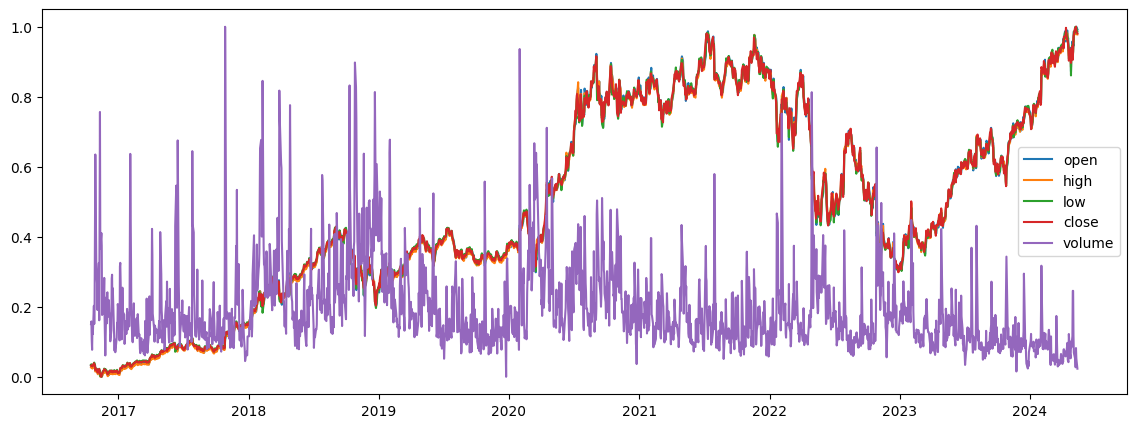

In [160]:
num_pipeline = Pipeline([
    ('std_scaler', MinMaxScaler())
])

data_prepared = num_pipeline.fit_transform(df[['open', 'high', 'low', 'close', 'volume', 'sentiment']])
#plot the features of data prepared on different graphs with x being date
plt.figure(figsize = (14, 5))
plt.plot(df.index, data_prepared[:,0], label='open')
plt.plot(df.index, data_prepared[:,1], label='high')
plt.plot(df.index, data_prepared[:,2], label='low')
plt.plot(df.index, data_prepared[:,3], label='close')
plt.plot(df.index, data_prepared[:,4], label='volume')
plt.legend()
plt.show()


In [ ]:
split = 0.85
splitIdx = int(split*len(df))
trainData = df[:splitIdx]
testData = df[splitIdx:]

In [ ]:
trainData = trainData.reshape(-1)

# Normalize test data
testData = scaler.transform(testData).reshape(-1)